In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/math482-2024-2025-1-hw-04/sample_submission.csv
/kaggle/input/math482-2024-2025-1-hw-04/train.csv
/kaggle/input/math482-2024-2025-1-hw-04/test.csv


# Summary
* In this problem, the relationship between features and target class is much more complex
* need to use deep learning methods
* feature engineering in this assignment
* the most important thing: *improve your model results by experimenting with hyperparameters.*
* dataset includes 21 feature columns (named "feature_01", "feature_02", …) and a target column ("target").
* The training dataset contains 22,500 rows, while the testing dataset has 7,500 rows.
* expected to build a neural network
* work on preparing your data and fine-tuning the hyperparameters of your model to get a good score.
* Experiment with different activation functions to see which one helps your model learn best.
* try out different optimizers like SGD, Adam, or RMSprop to find one that helps your model improve quickly and efficiently.
* To make sure your model does not overfit, you can use techniques like dropout or regularization.
* Changing the learning rate and momentum might also improve training.
* some preprocessing before building your models.
* there are some irrelevant (randomly generated and unrelated to the target value) columns.
* first task is to identify these columns - think about and research methods for detecting irrelevant and redundant features.
* Second, you need to convert your categorical variables to numerical ones, keeping in mind that some categorical features are inherently ordered, while others are not.
* apply some sort of encoding before using unordered categorical variables.
* Also, some columns contain null values, need to decide how to handle them before training
* check if there are any outliers and deal with this problem as well
* evaluation will consider both model accuracy and your approach to data analysis, interpretation, and code clarity
* Submissions will be evaluated using F1. Note that the average parameter is taken as 'micro'
* Compute the F1 y_pred, also known as balanced F-score or F-measure.
* The F1 score can be interpreted as a harmonic mean of the precision and
recall, where an F1 score reaches its best value at 1 and worst score at 0.


# Data Exploration


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import optuna
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer


# load the data

train_df = pd.read_csv('/kaggle/input/math482-2024-2025-1-hw-04/train.csv')
test_df = pd.read_csv('/kaggle/input/math482-2024-2025-1-hw-04/test.csv')


# data exploration

# Display basic information about the datasets
print("Training Data Info:")
print(train_df.info())
print("\nTesting Data Info:")
print(test_df.info())

# Display the first few rows of the datasets
print("\nTraining Data Preview:")
print(train_df.head())

print("\nTesting Data Preview:")
print(test_df.head())

# Check for null values
print("\nNull Values in Training Data:")
print(train_df.isnull().sum())

print("\nNull Values in Testing Data:")
print(test_df.isnull().sum())

# Summary statistics
print("\nSummary Statistics of Training Data:")
print(train_df.describe())


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          22500 non-null  int64  
 1   feature_01  20096 non-null  float64
 2   feature_02  19612 non-null  object 
 3   feature_03  20033 non-null  object 
 4   feature_04  20141 non-null  float64
 5   feature_05  20455 non-null  float64
 6   feature_06  19557 non-null  float64
 7   feature_07  19745 non-null  float64
 8   feature_08  20973 non-null  float64
 9   feature_09  19882 non-null  object 
 10  feature_10  20345 non-null  object 
 11  feature_11  19698 non-null  float64
 12  feature_12  19869 non-null  float64
 13  feature_13  19417 non-null  float64
 14  feature_14  21257 non-null  object 
 15  feature_15  20853 non-null  float64
 16  feature_16  20289 non-null  float64
 17  feature_17  19406 non-null  float64
 18  feature_18  21219 non-null  float64
 19  featu

**Initial Observation:**
* Missing values are consistent across both testing and training datasets
* In the training dataset, target values seem to range between 0 and 5, indicating a multi-class classification problem. Some numeric features (such as feature15, feature16) have very high ranges, suggesting potential scaling issues.
* In the testing dataset, some features have extreme values (such as feature12 with -114.94 and 143.41), suggesting potential outliers.

**What to do?**
* First thing to do is to handle missing values.

# Handling Missing Values 


In [3]:
# Handling Missing Values

# Imputation for missing numerical features using the median
numeric_features = train_df.select_dtypes(include=['float64', 'int64']).columns.drop('target')  # Exclude target
imputer = SimpleImputer(strategy='median')
train_df[numeric_features] = imputer.fit_transform(train_df[numeric_features])
test_df[numeric_features] = imputer.transform(test_df[numeric_features])

# Imputation for missing categorical features using the mode
categorical_features = train_df.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
train_df[categorical_features] = cat_imputer.fit_transform(train_df[categorical_features])
test_df[categorical_features] = cat_imputer.transform(test_df[categorical_features])


* The median is chosen as it is robust to outliers, ensuring that extreme values in the data do not disproportionately affect the imputed values.
* The mode (most frequent value) is used for categorical data because it is straightforward and effectively preserves the existing distribution of categories.
* Next thing to do: Feature Engineering

# Feature Engineering 


In [4]:
#feature engineering
ordinal_features = []
nominal_features = []

for feature in categorical_features:
    
    non_zero_values = train_df[feature].dropna().unique()
    has_number = any(any(char.isdigit() for char in str(value)) for value in non_zero_values)

    unique_values = train_df[feature].unique()
    
    # Check if all unique values match the ordinal pattern (uppercase letter and number)
    if has_number:
        ordinal_features.append(feature)
    else:
        nominal_features.append(feature)

# Print the identified ordinal and nominal features
print("Ordinal features:", ordinal_features)
print("Nominal features:", nominal_features)

Ordinal features: ['feature_02', 'feature_03', 'feature_10', 'feature_19']
Nominal features: ['feature_09', 'feature_14', 'feature_20']


In [5]:
ordinal_encoder = OrdinalEncoder()
train_df[ordinal_features] = ordinal_encoder.fit_transform(train_df[ordinal_features])
test_df[ordinal_features] = ordinal_encoder.transform(test_df[ordinal_features])

train_df = pd.get_dummies(train_df, columns=nominal_features, drop_first=True)
test_df = pd.get_dummies(test_df, columns=nominal_features, drop_first=True)

In [6]:
train_df, test_df = train_df.align(test_df, join='left', axis=1)
test_df.fillna(0, inplace=True)  # Fill any new columns with 0 in the test set
assert train_df.columns.equals(test_df.columns), "Mismatch between train and test columns after alignment"


*  Feature engineering for categorical features by dividing them into **ordinal** and **nominal** features and applying appropriate preprocessing
* Ordinal features: Encoded using OrdinalEncoder, which assigns numeric values based on the inherent order in the data
* Nominal features: Encoded using one-hot encoding via pd.get_dummies
* The **get_dummies()** function converts nominal variables into dummy/indicator variables (known as one-hot encoding). Each unique category in the original data is converted into a separate column, and the values are represented as True (for presence) or False (for absence).
* Using **drop_first=True** in pd.get_dummies avoids the dummy variable trap (multicollinearity).
* Alignment: Aligns train_df and test_df columns to ensure they have the same structure after encoding. Missing columns in the test set are filled with 0.
* Validation: Uses an **assert** statement to confirm that the train and test dataframes have identical columns after alignment.

# Handling Outliers

In [7]:
# Handling Outliers


# Handle outliers by scaling or flagging for analysis
outlier_flags = pd.DataFrame()
for feature in numeric_features:
    if feature == 'id':  # Skip 'id' as it's a unique identifier
        continue

    # Compute IQR bounds
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)].shape[0]
 


    if outliers > 0:
        # Flag outliers
        train_df[f"{feature}_outlier"] = (train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)
        outlier_flags[feature] = train_df[f"{feature}_outlier"]

        # Scale extreme values
        train_df[feature] = np.where(train_df[f"{feature}_outlier"], np.clip(train_df[feature], lower_bound, upper_bound), train_df[feature])
        print(f"Feature: {feature}, Outliers: {outliers}")


Feature: feature_01, Outliers: 1731
Feature: feature_04, Outliers: 839
Feature: feature_05, Outliers: 2327
Feature: feature_06, Outliers: 781
Feature: feature_07, Outliers: 1873
Feature: feature_08, Outliers: 2431
Feature: feature_11, Outliers: 1493
Feature: feature_12, Outliers: 2119
Feature: feature_13, Outliers: 1426
Feature: feature_15, Outliers: 1945
Feature: feature_16, Outliers: 1152
Feature: feature_17, Outliers: 1958
Feature: feature_18, Outliers: 1373
Feature: feature_21, Outliers: 2914


In [8]:
# Create a DataFrame to store outlier flags
test_outlier_flags = pd.DataFrame()

# Handle outliers in test data
for feature in numeric_features:
    if feature == 'id':  # Skip 'id' as it's a unique identifier
        continue

    # Compute IQR bounds using training data statistics
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers in test data
    outliers = test_df[(test_df[feature] < lower_bound) | (test_df[feature] > upper_bound)].shape[0]
    print(f"Feature: {feature}, Outliers in Test Data: {outliers}")

    # Flag outliers in the test data
    test_df[f"{feature}_outlier"] = (test_df[feature] < lower_bound) | (test_df[feature] > upper_bound)
    test_outlier_flags[feature] = test_df[f"{feature}_outlier"]

    # Scale (clip) outliers to within acceptable bounds
    test_df[feature] = np.where(
        test_df[f"{feature}_outlier"],
        np.clip(test_df[feature], lower_bound, upper_bound),
        test_df[feature]
    )

# Print the summary of outliers flagged
print("\nOutlier Summary for Test Data (Flag Counts):")
print(test_outlier_flags.sum())

# Verify the updated test data
print("\nUpdated Test Data Summary After Outlier Handling:")
print(test_df.describe())


Feature: feature_01, Outliers in Test Data: 564
Feature: feature_04, Outliers in Test Data: 311
Feature: feature_05, Outliers in Test Data: 738
Feature: feature_06, Outliers in Test Data: 240
Feature: feature_07, Outliers in Test Data: 662
Feature: feature_08, Outliers in Test Data: 842
Feature: feature_11, Outliers in Test Data: 480
Feature: feature_12, Outliers in Test Data: 707
Feature: feature_13, Outliers in Test Data: 469
Feature: feature_15, Outliers in Test Data: 684
Feature: feature_16, Outliers in Test Data: 395
Feature: feature_17, Outliers in Test Data: 641
Feature: feature_18, Outliers in Test Data: 457
Feature: feature_21, Outliers in Test Data: 969

Outlier Summary for Test Data (Flag Counts):
feature_01    564
feature_04    311
feature_05    738
feature_06    240
feature_07    662
feature_08    842
feature_11    480
feature_12    707
feature_13    469
feature_15    684
feature_16    395
feature_17    641
feature_18    457
feature_21    969
dtype: int64

Updated Test Dat

In [9]:
for feature in numeric_features:
    if feature == 'id':  # Skip 'id' as it's a unique identifier
        continue
    
    # Compute IQR bounds
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)].shape[0]

    print(f"Feature: {feature}, Outliers: {outliers}")


Feature: feature_01, Outliers: 0
Feature: feature_04, Outliers: 0
Feature: feature_05, Outliers: 0
Feature: feature_06, Outliers: 0
Feature: feature_07, Outliers: 0
Feature: feature_08, Outliers: 0
Feature: feature_11, Outliers: 0
Feature: feature_12, Outliers: 0
Feature: feature_13, Outliers: 0
Feature: feature_15, Outliers: 0
Feature: feature_16, Outliers: 0
Feature: feature_17, Outliers: 0
Feature: feature_18, Outliers: 0
Feature: feature_21, Outliers: 0


* IQR Outlier Detection: For each numeric feature, the IQR (75th percentile - 25th percentile) is calculated. IQR=Q3−Q1
* Lower Bound = Q1 − 1.5 × IQR and Upper Bound = Q3 + 1.5 × IQR
* For each numeric feature: Flag outlier values in a new column (e.g., feature_01_outlier), with True indicating an outlier.
* Replace outlier values by clipping them to the Lower Bound or Upper Bound to keep them within the acceptable range.


# Feature Analysis


Top 10 Important Features:
       Feature  Importance
12  feature_15    0.074968
4   feature_05    0.064762
11  feature_13    0.061435
13  feature_16    0.056621
0   feature_01    0.055604
9   feature_11    0.054541
7   feature_08    0.053655
10  feature_12    0.052782
14  feature_17    0.052605
17  feature_21    0.051146


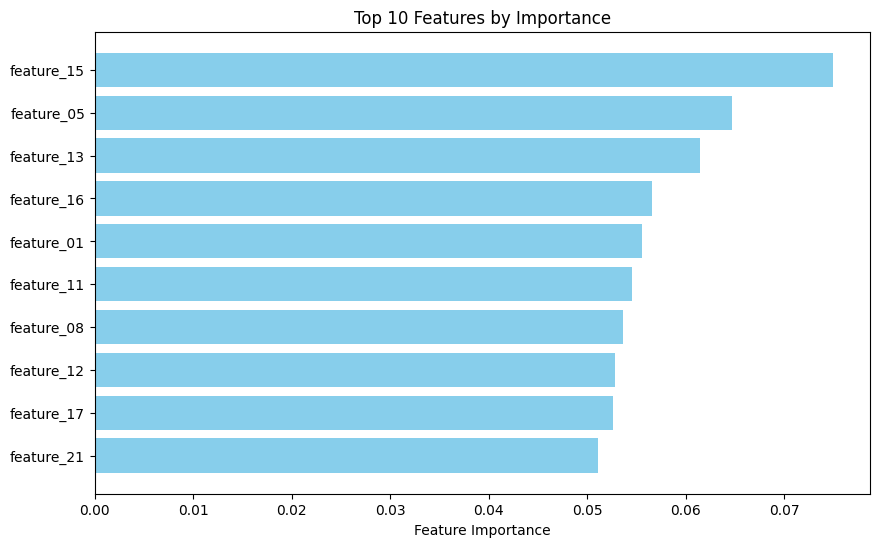

Selected Features (Importance > 0.01):
['feature_15', 'feature_05', 'feature_13', 'feature_16', 'feature_01', 'feature_11', 'feature_08', 'feature_12', 'feature_17', 'feature_21', 'feature_18', 'feature_06', 'feature_07', 'feature_03', 'feature_19', 'feature_04', 'feature_10', 'feature_02', 'feature_14_q', 'feature_20_ad']


In [10]:
#FEATURE ANALYSIS

# Step 1: Data Preparation
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare features (drop irrelevant columns) and target variable
X_train = train_df.drop(columns=['id', 'target'])  
y_train = train_df['target']

# Scale features using RobustScaler (optional for Random Forest)
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Step 2: Train Random Forest for Feature Importance
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the top features
print("Top 10 Important Features:")
print(feature_importances.head(10))

# Step 3: Visualize Feature Importances
top_features = feature_importances.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Show the most important feature on top
plt.xlabel('Feature Importance')
plt.title('Top 10 Features by Importance')
plt.show()

# Step 4: Filter Important Features (Optional)
# Threshold for importance (adjust based on results)
threshold = 0.01
selected_features = feature_importances[feature_importances['Importance'] > threshold]['Feature']
X_train_selected = X_train[selected_features]
print(f"Selected Features (Importance > {threshold}):")
print(selected_features.tolist())


* Scales features using **RobustScaler** to handle potential outliers and normalize data without being overly influenced by extreme values.
* A **RandomForestClassifier** is trained to estimate feature importance based on how each feature contributes to the classification task.
* Filters features with an importance score above a threshold
* Feature importance helps understand which variables influence the target most, providing insights into the data.


In [11]:

# Align train_df and test_df to ensure consistent columns
train_df, test_df = train_df.align(test_df, join='left', axis=1)
# Fill missing columns in test_df based on train_df patterns
for column in test_df.columns:
    if column not in train_df.columns:
        # If the column doesn't exist in train_df, fill with 0
        test_df[column] = 0
    else:
        # If the column exists, fill missing values with the mean from train_df
        test_df[column].fillna(train_df[column].mean(), inplace=True)


# Identify boolean columns in each DataFrame
bool_columns_train = train_df.select_dtypes('bool').columns
bool_columns_test = test_df.select_dtypes('bool').columns

# Convert boolean columns to integers
train_df[bool_columns_train] = train_df[bool_columns_train].astype(int)
test_df[bool_columns_test] = test_df[bool_columns_test].astype(int)


* Aligning train_df and test_df ensures that both datasets have identical column structures
* Converting boolean columns to integers (0 and 1) ensures compatibility with machine learning models


Number of data points in each target class:
target
5    5830
3    5614
1    5289
0    2209
2    1931
4    1627
Name: count, dtype: int64


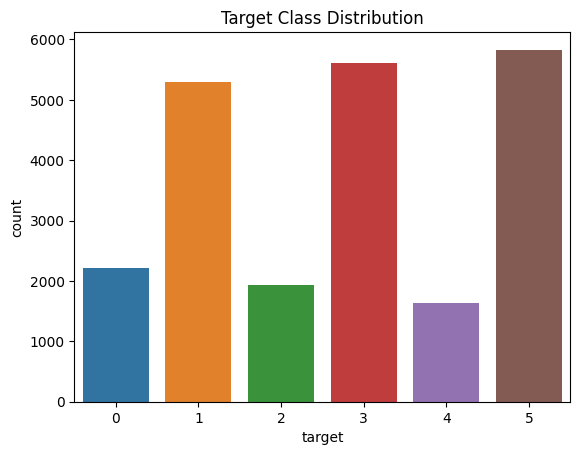

In [12]:
# Check for class imbalance in the target variable

class_counts = train_df['target'].value_counts()

# Display the counts
print("Number of data points in each target class:")
print(class_counts)

sns.countplot(x='target', data=train_df)
plt.title("Target Class Distribution")
plt.show()

In [13]:
from imblearn.over_sampling import SMOTE

sampling_strategy = {
    0: 4400,  # Double class 0
    1: 5830,  # Keep majority class 1 as is
    2: 3862,  # Double class 2
    3: 5830,  # Keep majority class 3 as is
    4: 3254,  # Double class 4
    5: 5830,  # Keep majority class 5 as is
}


smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
X = train_df.drop(columns=['id', 'target'])
y = train_df['target']
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

print("SMOTE applied: Resampled class distribution")
print(pd.Series(y_train_resampled).value_counts())

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X_train.columns)


SMOTE applied: Resampled class distribution
target
1    5830
5    5830
3    5830
0    4400
2    3862
4    3254
Name: count, dtype: int64


* **SMOTE (Synthetic Minority Oversampling Technique)**: Generates synthetic samples for underrepresented classes to balance the dataset.
* Oversample smaller classes (e.g., class 0, class 2, class 4)
* Retain the size of majority classes (class 1, class 3, class 5)
* **RobustScaler** to scale the resampled dataset, making it robust to outliers while normalizing feature values.
* Ensuring that the model does not favor majority classes, improving its ability to generalize across all classes.



* Now we need to check everything is okay after SMOTE:

In [14]:
# Check for missing values 
print("Check for Missing Values in Training Data:")
print(X_train_resampled.isnull().sum().sum())

print("Check for Missing Values in Testing Data:")
print(test_df.isnull().sum().sum())

# Verify alignment of train and test datasets
print("Training Data Columns:")
print(X_train_resampled.columns)

print("Testing Data Columns:")
print(test_df.columns)

# Check feature scaling
print("Summary Statistics of Training Data:")
print(X_train_resampled.describe())


# Ensure there are no outliers in numeric features 
for feature in numeric_features:
    if feature not in X_train_resampled.columns:
        continue  # Skip if feature is not in resampled training data
    print(f"Feature: {feature}, Outliers: ", 
          X_train_resampled[(X_train_resampled[feature] < X_train_resampled[feature].quantile(0.25) - 1.5 * (X_train_resampled[feature].quantile(0.75) - X_train_resampled[feature].quantile(0.25))) |
                           (X_train_resampled[feature] > X_train_resampled[feature].quantile(0.75) + 1.5 * (X_train_resampled[feature].quantile(0.75) - X_train_resampled[feature].quantile(0.25)))].shape[0])

# Ensure target variable distribution is balanced
print("Target Variable Distribution:")
print(y_train_resampled.value_counts())


Check for Missing Values in Training Data:
0
Check for Missing Values in Testing Data:
0
Training Data Columns:
Index(['feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05',
       'feature_06', 'feature_07', 'feature_08', 'feature_10', 'feature_11',
       'feature_12', 'feature_13', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'feature_19', 'feature_21', 'feature_09_xy',
       'feature_09_yx', 'feature_09_yy', 'feature_14_q', 'feature_14_r',
       'feature_14_s', 'feature_14_t', 'feature_14_u', 'feature_20_ab',
       'feature_20_ac', 'feature_20_ad', 'feature_20_ae', 'feature_01_outlier',
       'feature_04_outlier', 'feature_05_outlier', 'feature_06_outlier',
       'feature_07_outlier', 'feature_08_outlier', 'feature_11_outlier',
       'feature_12_outlier', 'feature_13_outlier', 'feature_15_outlier',
       'feature_16_outlier', 'feature_17_outlier', 'feature_18_outlier',
       'feature_21_outlier'],
      dtype='object')
Testing Data Columns:


In [15]:
for feature in numeric_features:
    if feature not in X_train_resampled.columns:  # Skip if feature is not in resampled training data
        continue

    # Compute IQR bounds
    Q1 = X_train_resampled[feature].quantile(0.25)
    Q3 = X_train_resampled[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = X_train_resampled[(X_train_resampled[feature] < lower_bound) | (X_train_resampled[feature] > upper_bound)].shape[0]
 

if outliers > 0:
        # Flag outliers
        X_train_resampled[f"{feature}_outlier"] = (X_train_resampled[feature] < lower_bound) | (X_train_resampled[feature] > upper_bound)
        outlier_flags[feature] = X_train_resampled[f"{feature}_outlier"]

        # Scale extreme values
        X_train_resampled[feature] = np.where(X_train_resampled[f"{feature}_outlier"], np.clip(X_train_resampled[feature], lower_bound, upper_bound), X_train_resampled[feature])

for feature in numeric_features:
    if feature not in X_train_resampled.columns:  # Skip if feature is not in resampled training data
        continue
    print(f"Feature: {feature}, Outliers: ", 
          X_train_resampled[(X_train_resampled[feature] < X_train_resampled[feature].quantile(0.25) - 1.5 * (X_train_resampled[feature].quantile(0.75) - X_train_resampled[feature].quantile(0.25))) |
                           (X_train_resampled[feature] > X_train_resampled[feature].quantile(0.75) + 1.5 * (X_train_resampled[feature].quantile(0.75) - X_train_resampled[feature].quantile(0.25)))].shape[0])


Feature: feature_01, Outliers:  2246
Feature: feature_04, Outliers:  0
Feature: feature_05, Outliers:  0
Feature: feature_06, Outliers:  0
Feature: feature_07, Outliers:  1999
Feature: feature_08, Outliers:  3172
Feature: feature_11, Outliers:  1734
Feature: feature_12, Outliers:  2361
Feature: feature_13, Outliers:  1723
Feature: feature_15, Outliers:  0
Feature: feature_16, Outliers:  1398
Feature: feature_17, Outliers:  2197
Feature: feature_18, Outliers:  1516
Feature: feature_21, Outliers:  0


In [16]:
for feature in numeric_features:
    if feature not in X_train_resampled.columns:
        continue

    # Compute IQR bounds
    Q1 = X_train_resampled[feature].quantile(0.25)
    Q3 = X_train_resampled[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip the synthetic samples
    X_train_resampled[feature] = np.clip(X_train_resampled[feature], lower_bound, upper_bound)

for feature in numeric_features:
    if feature not in X_train_resampled.columns:  # Skip if feature is not in resampled training data
        continue
    print(f"Feature: {feature}, Outliers: ", 
          X_train_resampled[(X_train_resampled[feature] < X_train_resampled[feature].quantile(0.25) - 1.5 * (X_train_resampled[feature].quantile(0.75) - X_train_resampled[feature].quantile(0.25))) |
                           (X_train_resampled[feature] > X_train_resampled[feature].quantile(0.75) + 1.5 * (X_train_resampled[feature].quantile(0.75) - X_train_resampled[feature].quantile(0.25)))].shape[0])


Feature: feature_01, Outliers:  0
Feature: feature_04, Outliers:  0
Feature: feature_05, Outliers:  0
Feature: feature_06, Outliers:  0
Feature: feature_07, Outliers:  0
Feature: feature_08, Outliers:  0
Feature: feature_11, Outliers:  0
Feature: feature_12, Outliers:  0
Feature: feature_13, Outliers:  0
Feature: feature_15, Outliers:  0
Feature: feature_16, Outliers:  0
Feature: feature_17, Outliers:  0
Feature: feature_18, Outliers:  0
Feature: feature_21, Outliers:  0


In [17]:
# Scale selected features to emphasize their importance
selected_feature_ranges = X_train_resampled[selected_features].describe().loc[['min', 'max']]
print("Selected Feature Ranges:\n", selected_feature_ranges)
scaling_factors = {}
for feature in selected_features:
    range_value = X_train_resampled[feature].max() - X_train_resampled[feature].min()
    scaling_factors[feature] = 2 / (range_value + 1e-6)  # Small constant to avoid division by zero

# Apply the scaling
for feature in selected_features:
    if feature in X_train_resampled.columns:
        X_train_resampled[feature] *= scaling_factors[feature]
    if feature in test_df.columns:
        test_df[feature] *= scaling_factors[feature]


# Align datasets to ensure consistent columns
train_df, test_df = train_df.align(test_df, join='left', axis=1)
test_df.fillna(0, inplace=True)  # Fill missing columns in test data with 0

# Display updated datasets
print("\nTraining Data Preview (after feature scaling):")
print(X_train_resampled.head())

print("\nTesting Data Preview (after feature scaling):")
print(test_df.head())



for feature in numeric_features:
    if feature not in X_train_resampled.columns:  # Skip if feature is not in resampled training data
        continue
    print(f"Feature: {feature}, Outliers: ", 
          X_train_resampled[(X_train_resampled[feature] < X_train_resampled[feature].quantile(0.25) - 1.5 * (X_train_resampled[feature].quantile(0.75) - X_train_resampled[feature].quantile(0.25))) |
                           (X_train_resampled[feature] > X_train_resampled[feature].quantile(0.75) + 1.5 * (X_train_resampled[feature].quantile(0.75) - X_train_resampled[feature].quantile(0.25)))].shape[0])


Selected Feature Ranges:
      feature_15  feature_05  feature_13  feature_16  feature_01  feature_11  \
min        0.00     0.02000      -9.245       -9.62    0.000000      -3.335   
max        6.23     4.04875       2.825        2.94    5.530383       1.345   

     feature_08  feature_12  feature_17  feature_21  feature_18  feature_06  \
min       0.000   -3.518046      -3.385       0.020    0.030000       0.045   
max       6.705    1.438827       1.295       4.475    0.778022       0.725   

     feature_07  feature_03  feature_19  feature_04  feature_10  feature_02  \
min       0.030         0.0         0.0         0.0         0.0         0.0   
max       0.785         5.0         5.0         5.0         5.0         3.0   

     feature_14_q  feature_20_ad  
min           0.0            0.0  
max           1.0            1.0  

Training Data Preview (after feature scaling):
   feature_01  feature_02  feature_03  feature_04  feature_05  feature_06  \
0    0.339940    0.666666     

* Feature scaling for selected features: Computes the range for each selected feature and calculates a scaling factor as 2/range
* Applies the scaling factor to both the **X_train_resampled** and the **test_df**
* Scaling factors are calculated carefully to prevent division by zero (1e-6 added as a small constant).





In [18]:
for feature in numeric_features:
    if feature not in X_train_resampled.columns:
        continue

    # Compute IQR bounds
    Q1 = X_train_resampled[feature].quantile(0.25)
    Q3 = X_train_resampled[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip the synthetic samples
    X_train_resampled[feature] = np.clip(X_train_resampled[feature], lower_bound, upper_bound)

for feature in numeric_features:
    if feature not in X_train_resampled.columns:  # Skip if feature is not in resampled training data
        continue
    print(f"Feature: {feature}, Outliers: ", 
          X_train_resampled[(X_train_resampled[feature] < X_train_resampled[feature].quantile(0.25) - 1.5 * (X_train_resampled[feature].quantile(0.75) - X_train_resampled[feature].quantile(0.25))) |
                           (X_train_resampled[feature] > X_train_resampled[feature].quantile(0.75) + 1.5 * (X_train_resampled[feature].quantile(0.75) - X_train_resampled[feature].quantile(0.25)))].shape[0])


Feature: feature_01, Outliers:  0
Feature: feature_04, Outliers:  0
Feature: feature_05, Outliers:  0
Feature: feature_06, Outliers:  0
Feature: feature_07, Outliers:  0
Feature: feature_08, Outliers:  0
Feature: feature_11, Outliers:  0
Feature: feature_12, Outliers:  0
Feature: feature_13, Outliers:  0
Feature: feature_15, Outliers:  0
Feature: feature_16, Outliers:  0
Feature: feature_17, Outliers:  0
Feature: feature_18, Outliers:  0
Feature: feature_21, Outliers:  0


* The code now flags and clips outliers efficiently for all numeric features, ensuring consistent preprocessing across both datasets.


# Neural Network


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters
    hidden_layers = trial.suggest_int('hidden_layers', 1, 3)
    neurons = trial.suggest_int('neurons_per_layer', 32, 128, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'AdamW'])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    activation_function = trial.suggest_categorical('activation', ['ReLU', 'tanh'])

    # Prepare data
    X = train_df.drop(columns=['id', 'target'])
    y = train_df['target']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})
    X_val = X_val.astype({col: 'int' for col in X_val.select_dtypes('bool').columns})

    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define model
    class CustomNeuralNetwork(nn.Module):
        def __init__(self, input_size, num_classes, hidden_layers, neurons, dropout_rate, activation_function):
            super(CustomNeuralNetwork, self).__init__()
            layers = []
            for _ in range(hidden_layers):
                layers.append(nn.Linear(input_size, neurons))
                layers.append(nn.BatchNorm1d(neurons))
                if activation_function == 'ReLU':
                    layers.append(nn.ReLU())
                elif activation_function == 'tanh':
                    layers.append(nn.Tanh())
                layers.append(nn.Dropout(dropout_rate))
                input_size = neurons
            layers.append(nn.Linear(input_size, num_classes))
            self.fc = nn.Sequential(*layers)

        def forward(self, x):
            return self.fc(x)

    model = CustomNeuralNetwork(
        input_size=X_train.shape[1],
        num_classes=len(y.unique()),
        hidden_layers=hidden_layers,
        neurons=neurons,
        dropout_rate=dropout_rate,
        activation_function=activation_function
    )
    model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Optimizer and scheduler
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

    # Training loop
    epochs = 10
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Validation phase
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for val_X, val_y in val_loader:
            outputs = model(val_X)
            _, preds = torch.max(outputs, 1)
            val_predictions.extend(preds.cpu().numpy())
            val_targets.extend(val_y.cpu().numpy())

    # Calculate F1 score
    val_f1 = f1_score(val_targets, val_predictions, average='micro')
    return val_f1

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  
# Print best parameters and F1 score
print("Best Parameters:", study.best_params)
print("Best F1 Score:", study.best_value)


[I 2024-12-29 20:15:08,739] A new study created in memory with name: no-name-e210804f-7080-4c00-a132-7c9dc1bf4dd0
[I 2024-12-29 20:15:21,498] Trial 0 finished with value: 0.4093333333333333 and parameters: {'hidden_layers': 1, 'neurons_per_layer': 78, 'optimizer': 'AdamW', 'lr': 0.00020668020556675735, 'dropout_rate': 0.31211826144991367, 'batch_size': 32, 'activation': 'ReLU'}. Best is trial 0 with value: 0.4093333333333333.
[I 2024-12-29 20:15:27,547] Trial 1 finished with value: 0.412 and parameters: {'hidden_layers': 1, 'neurons_per_layer': 49, 'optimizer': 'RMSprop', 'lr': 0.002963436852704455, 'dropout_rate': 0.29888142406494433, 'batch_size': 64, 'activation': 'ReLU'}. Best is trial 1 with value: 0.412.
[I 2024-12-29 20:15:33,107] Trial 2 finished with value: 0.37933333333333336 and parameters: {'hidden_layers': 2, 'neurons_per_layer': 123, 'optimizer': 'RMSprop', 'lr': 0.00011870322606870715, 'dropout_rate': 0.49647240963867945, 'batch_size': 128, 'activation': 'tanh'}. Best is

Best Parameters: {'hidden_layers': 2, 'neurons_per_layer': 35, 'optimizer': 'Adam', 'lr': 0.0020909742205141467, 'dropout_rate': 0.23628150726565322, 'batch_size': 64, 'activation': 'ReLU'}
Best F1 Score: 0.42044444444444445


* Objective function: Defines the structure of the neural network and hyperparameters to optimize.Splits data into training and validation sets. Converts the data to PyTorch tensors and creates DataLoader objects.
* Model: Constructs a flexible neural network with the specified number of layers and neurons. Uses Batch Normalization, ReLU activation, and Dropout (0.3) to improve generalization.
* Trains the model for 10 epochs using the selected optimizer and learning rate.
* Uses cross-entropy loss as the criterion for classification.
* Implements learning rate scheduling with StepLR.

* 20 trials, testing various combinations of hyperparameters to maximize the F1 score.


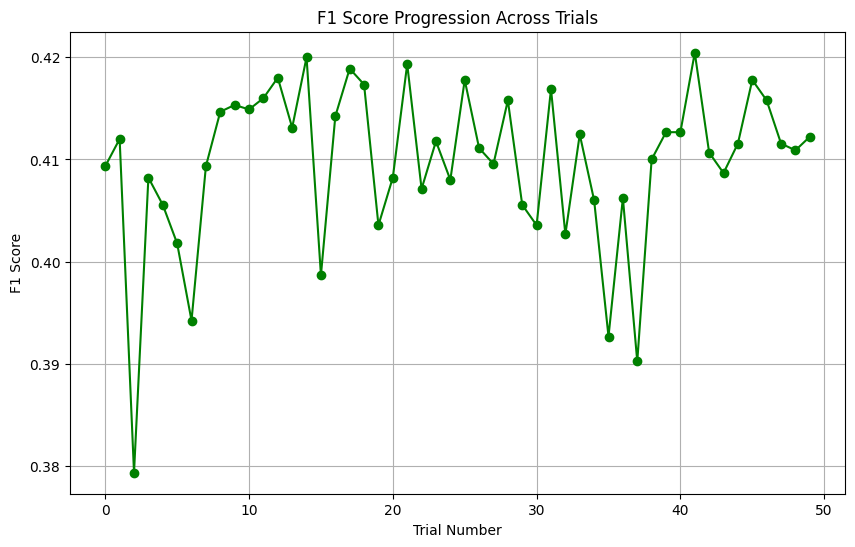

<ipython-input-20-22029cfa0ed5>:15: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_viz.plot_param_importances(study)


<Figure size 1000x600 with 0 Axes>

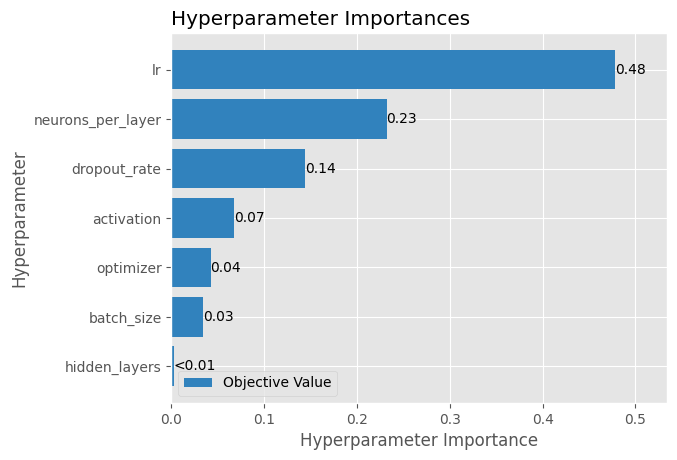

<ipython-input-20-22029cfa0ed5>:21: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_viz.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

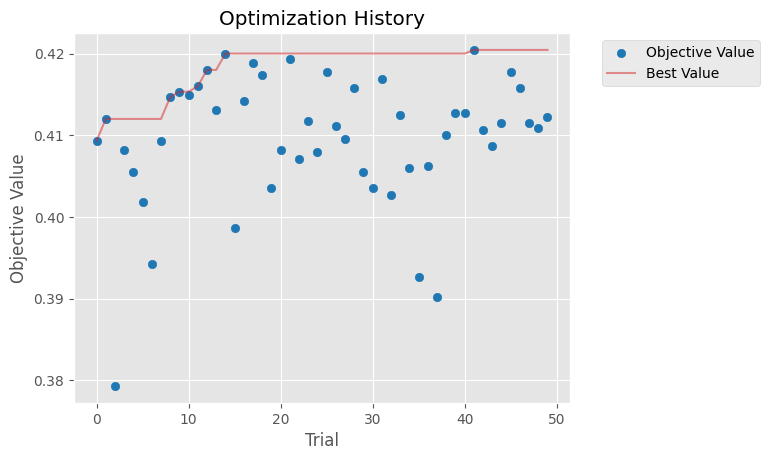

In [20]:
import optuna.visualization.matplotlib as optuna_viz

# Plot the F1 score progression across trials
f1_scores = [trial.value for trial in study.trials]
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores)), f1_scores, marker='o', linestyle='-', color='green')
plt.title("F1 Score Progression Across Trials")
plt.xlabel("Trial Number")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

# Plot hyperparameter importance
plt.figure(figsize=(10, 6))
optuna_viz.plot_param_importances(study)
plt.show()


# Visualize optimization history
plt.figure(figsize=(10, 6))
optuna_viz.plot_optimization_history(study)
plt.title("Optimization History")
plt.show()


* how the F1 score evolves over the trials, helping identify trends and convergence.
* the relative importance of each hyperparameter based on its impact on the objective metric (F1 score).
* detailed view of the progression of the optimization process, showing the best value achieved at each trial.


In [21]:
X_train_resampled = X_train_resampled.astype(float)

# Use best parameters to train final model
best_params = study.best_params

# Prepare final data
X = train_df.drop(columns=['id', 'target'])
y = train_df['target']
X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)

final_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
final_loader = torch.utils.data.DataLoader(final_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Define final model
class FinalNeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers, neurons, dropout_rate, activation_function):
        super(FinalNeuralNetwork, self).__init__()
        layers = []
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_size, neurons))
            layers.append(nn.BatchNorm1d(neurons))
            if activation_function == 'ReLU':
                layers.append(nn.ReLU())
            elif activation_function == 'tanh':
                layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
            input_size = neurons
        layers.append(nn.Linear(input_size, num_classes))
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(x)

final_model = FinalNeuralNetwork(
    input_size=X.shape[1],
    num_classes=len(y.unique()),
    hidden_layers=best_params['hidden_layers'],
    neurons=best_params['neurons_per_layer'],
    dropout_rate=best_params['dropout_rate'],
    activation_function=best_params['activation']
)
final_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Optimizer and criterion
if best_params['optimizer'] == 'Adam':
    final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])
elif best_params['optimizer'] == 'RMSprop':
    final_optimizer = optim.RMSprop(final_model.parameters(), lr=best_params['lr'])
elif best_params['optimizer'] == 'AdamW':
    final_optimizer = optim.AdamW(final_model.parameters(), lr=best_params['lr'])

final_criterion = nn.CrossEntropyLoss()

# Training final model
epochs = 60
for epoch in range(epochs):
    final_model.train()
    epoch_loss = 0
    train_predictions = []
    train_targets = []

    for batch_X, batch_y in final_loader:
        final_optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = final_criterion(outputs, batch_y)
        loss.backward()
        final_optimizer.step()
        epoch_loss += loss.item()

        # Collect predictions for F1 score
        _, preds = torch.max(outputs, 1)
        train_predictions.extend(preds.cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())

    # Calculate F1 score for this epoch
    f1_train = f1_score(train_targets, train_predictions, average='micro')
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, F1 Score: {f1_train:.4f}")

# Evaluate model on train data for F1 score
final_model.eval()
train_predictions = []
train_targets = []
with torch.no_grad():
    for batch_X, batch_y in final_loader:
        outputs = final_model(batch_X)
        _, preds = torch.max(outputs, 1)
        train_predictions.extend(preds.cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())

f1_train = f1_score(train_targets, train_predictions, average='micro')
print(f"Final Model F1 Score on Train Data: {f1_train:.4f}")


Epoch 1/60, Loss: 702.5482, F1 Score: 0.3301
Epoch 2/60, Loss: 655.4168, F1 Score: 0.3791
Epoch 3/60, Loss: 647.4126, F1 Score: 0.3895
Epoch 4/60, Loss: 642.8796, F1 Score: 0.3953
Epoch 5/60, Loss: 639.8258, F1 Score: 0.3992
Epoch 6/60, Loss: 637.9975, F1 Score: 0.3988
Epoch 7/60, Loss: 635.9306, F1 Score: 0.4000
Epoch 8/60, Loss: 635.2153, F1 Score: 0.4045
Epoch 9/60, Loss: 633.9128, F1 Score: 0.4073
Epoch 10/60, Loss: 632.9845, F1 Score: 0.4080
Epoch 11/60, Loss: 633.9027, F1 Score: 0.4053
Epoch 12/60, Loss: 632.6238, F1 Score: 0.4039
Epoch 13/60, Loss: 631.3997, F1 Score: 0.4047
Epoch 14/60, Loss: 631.5802, F1 Score: 0.4068
Epoch 15/60, Loss: 631.2114, F1 Score: 0.4132
Epoch 16/60, Loss: 631.1631, F1 Score: 0.4056
Epoch 17/60, Loss: 629.8728, F1 Score: 0.4076
Epoch 18/60, Loss: 631.1291, F1 Score: 0.4089
Epoch 19/60, Loss: 630.5056, F1 Score: 0.4072
Epoch 20/60, Loss: 630.2934, F1 Score: 0.4102
Epoch 21/60, Loss: 628.8429, F1 Score: 0.4094
Epoch 22/60, Loss: 628.4350, F1 Score: 0.41

* The decreasing loss suggests that the model is converging and fitting the training data well.
* The improvement in F1 score demonstrates better classification performance over time.

In [22]:
# Prepare test data
# Drop the 'id' column from the test dataset to match the training feature structure
X_test = test_df.drop(columns=['id'])

# Ensure test data has the same columns as training data, filling missing ones with 0
X_train_columns = train_df.drop(columns=['id', 'target']).columns  # Get feature columns from training data
X_test = X_test.reindex(columns=X_train_columns, fill_value=0)  # Align test data with training feature set

# Convert test data to PyTorch tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Make predictions on test data using the trained model
final_model.eval()  # Set model to evaluation mode
predictions = []
with torch.no_grad():  # Disable gradient computation
    outputs = final_model(X_test_tensor)  # Forward pass on test data
    _, preds = torch.max(outputs, 1)  # Get predicted class for each data point
    predictions.extend(preds.cpu().numpy())  # Store predictions as a numpy array

# Prepare the submission file
submission = pd.DataFrame({
    'id': test_df['id'],  # Include the 'id' column from the test dataset
    'target': predictions  # Add predictions as the 'target' column
})

# Save the submission file as a CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")


Submission file created: submission.csv
